# 🎯 | Cora-For-Zava: Advanced Model Distillation

환영합니다! 이 노트북에서는 모델 증류를 사용하여 품질 기준을 유지하면서 크고 값비싼 모델에서 더 작고 빠르며 비용 효율적인 모델로 전문 지식을 이전하는 방법을 보여줍니다.

## 🛒 Zava 시나리오

**Cora**는 DIY 애호가를 위한 홈 인테리어 용품을 판매하는 가상의 소매업체 **Zava**의 고객 서비스 챗봇입니다. 뛰어난 음색과 스타일을 위해 모델을 세밀하게 조정했지만, 특정 작업을 위해 크고 값비싼 모델(GPT-4)을 사용하고 있습니다. 이 노트북에서는 비용 효율성과 성능을 최적화하기 위해 해당 전문 지식을 더 작은 모델(GPT-4.1-nano)로 증류하는 방법을 보여줍니다.

## 🎯 완성 목표

이 노트북을 마치면 다음을 달성하게 됩니다.
- ✅ Azure AI Foundry의 평가 및 미세 조정 기능을 사용하여 모델 증류 파이프라인 구성
- ✅ 사용자 지정 그레이더를 사용하여 기준 모델 성능 측정
- ✅ 증류 기법을 적용하여 더 작은 모델로 지식 전달
- ✅ 증류된 모델이 품질 표준을 유지하는지 검증
- ✅ 비용, 속도 및 효율성 측면에서 성능 향상 측정
- ✅ 최적화된 모델을 프로덕션 환경에 배포

## 💡 학습 목표

- 엔드투엔드 모델 증류 워크플로우 구현 방법
- Azure AI Foundry의 평가 및 미세 조정 서비스를 함께 사용하는 방법
- 모델 기능과 비용 및 성능 요구 사항 간의 균형 유지 방법
- 사용자 지정 그레이더를 사용하여 증류 효과 검증 방법
- 품질 저하 없이 모델 효율성 측정 및 최적화 방법
- 증류가 다른 최적화 접근 방식보다 최고의 ROI를 제공하는 경우

> **핵심 개념**: 모델 증류는 다음과 같은 이점을 제공합니다. 더 크고 성능이 뛰어난 "교사" 모델로부터 학습하여 더 작은 모델이 특화된 작업을 수행하도록 "학습"시킴으로써 비용과 성능을 획기적으로 개선할 수 있습니다.

AI를 최적화하여 최대 효율을 달성할 준비가 되셨나요? 지금 바로 시작해 보세요! 🚀

---

## Step 1: Verify Environment Variables

The following environment variables should already be configured in your `.env` file from the earlier setup steps:

- **AZURE_OPENAI_API_KEY**: Your Azure OpenAI API key
  - 제거하고 SystemManagedIdentity 사용 예정
- **AZURE_OPENAI_ENDPOINT**: Your Azure OpenAI service endpoint
- **AZURE_OPENAI_API_VERSION**: The API version (2025-02-01-preview for distillation features)
- **AZURE_SUBSCRIPTION_ID**: Your Azure subscription ID
- **AZURE_RESOURCE_GROUP**: Your Azure resource group name
- **AZURE_AI_PROJECT_NAME**: Your Azure AI Foundry project name

> **Important**: Distillation requires access to both teacher models (large, capable) and student models (small, efficient). This notebook uses GPT-4 as the teacher and GPT-4.1-nano as the student model.

In [1]:
# First, make sure required environment variables are set
import os

openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
model_name = "gpt-4.1"
api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2025-02-01-preview")

print("Using Model:", model_name)
print("Using API Version:", api_version)

Using Model: gpt-4.1
Using API Version: 2025-02-01-preview


In [2]:
# Then create an Azure OpenAI Client instance
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    azure_ad_token_provider=get_bearer_token_provider(
        DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"),
    api_version="2025-04-01-preview",
)

In [3]:
# And create a handy UUID we can use to track each run of this notebook
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

## Step 2: 지식 증류 실행

지식 증류는 "교사" 모델에서 "학생" 모델로 특화된 기능을 이전하는 과정입니다. 이 과정을 통해 더 작은 모델이 특정 작업에서 더 큰 모델과 유사한 성능을 달성할 수 있습니다.

### 🧠 증류 프로세스 개요

**Teacher Model** → **Knowledge Transfer** → **Student Model**
- 크고 비싸지만 강력한 모델 → 특화된 학습 데이터 → 작고 빠르며 비용 효율적인 모델

**주요 이점**:
- **비용 절감**: 더 작은 모델은 추론에 더 적은 토큰을 사용합니다.
- **성능 향상**: 더 빠른 응답 시간과 더 높은 처리량을 제공합니다.
- **품질 유지**: 특화된 작업 성능을 유지합니다.
- **확장성**: 리소스가 제한된 환경에서도 배포가 가능합니다.

### 2.1 최적의 교사 모델 선정

사용자 지정 평가 도구의 평가 결과를 불러와 가장 우수한 성능을 보이는 모델을 선정합니다. 이 "최우수" 모델이 정제 과정의 교사 모델이 됩니다.

**선정 기준**:
- **품질 점수**: 어조 및 스타일에 대한 최고 등급 평가
- **일관성**: 다양한 고객 시나리오에서 안정적인 성능
- **Zava 표준**: 정중하고, 도움이 되며, 사실에 입각한 응답 패턴을 가장 잘 준수

> **데이터 출처**: 평가 파이프라인의 연속성을 보장하기 위해 이전 사용자 지정 평가 도구 노트북(`32-distillation_export.json`)에서 내보낸 결과를 사용합니다.

In [4]:
import json
from openai import AzureOpenAI

# Load exported data from grader notebook
with open('32-distillation_export.json', 'r') as f:
    export_data = json.load(f)

# Reconstruct the baseline runs
baseline_eval_id = export_data['baseline_eval_id']
baseline_runs = []

for i, run_id in enumerate(export_data['baseline_runs_ids']):
    run = client.evals.runs.retrieve(eval_id=baseline_eval_id, run_id=run_id)
    # Ensure model name is set
    run.model = export_data['baseline_runs_models'][i]
    baseline_runs.append(run)

# Get other variables
baseline_eval = client.evals.retrieve(baseline_eval_id)
qa_validation = export_data['qa_validation']
GRADER_MODEL = export_data['GRADER_MODEL']
GRADER_PROMPT = export_data['GRADER_PROMPT']
SYSTEM_PROMPT = export_data['SYSTEM_PROMPT']

print(f"✅ Loaded {len(baseline_runs)} baseline runs from grader notebook")
print(f"✅ Loaded {len(qa_validation)} validation Q&A pairs")

✅ Loaded 5 baseline runs from grader notebook
✅ Loaded 153 validation Q&A pairs


In [5]:
# Composite metric based teacher/student selection
# Uses existing score_distribution + HIGH_SCORES already populated above

import math
from statistics import mean

CUTOFF = 4.0
HIGH_SCORES = {
    "o3-mini": [],
    "o4-mini": [],
    "gpt-4o-mini": [],
    "gpt-4.1-mini": [],
    "gpt-4.1-nano": [],
}

# Let's find our responses that were Excellent (at or above CUTOFF). We'll collect them
# and pre-format them into chat completions format to save time later.
#
# This part is honestly a bit tricky...we're extracting the prompts and responses for the
# model under test and *not* the prompts to the grader, so we have to do surgery. 🔪
for run in baseline_runs:
    pages = client.evals.runs.output_items.list(
        run.id, eval_id=baseline_eval.id).iter_pages()
    for page in pages:
        for item in page.data:
            # We only used 1 grader. If you use multiple, you should look for which ones you want.
            if not item.results:
                continue
            result = item.results[0]
            # FIX: Use attribute access for score and sample
            if result.score >= CUTOFF:
                generated = result.sample["input"][-1]["content"].strip().split("\nA: ")
                question = generated[0][3:]  # drops the "Q: "
                answer = generated[-1]
                messages = [
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": question},
                    {"role": "assistant", "content": answer},
                ]
                HIGH_SCORES[run.model].append({"messages": messages})

# 1. Collect raw score lists for each model (recompute if needed)
score_distribution = {}
for run in baseline_runs:
    score_distribution.setdefault(run.model, [])
    pages = client.evals.runs.output_items.list(
        run.id, eval_id=baseline_eval.id).iter_pages()
    for page in pages:
        for item in page.data:
            if not item.results:
                continue
            result = item.results[0]
            # FIX: Use attribute access for score
            if hasattr(result, "score"):
                score_distribution[run.model].append(result.score)

# 2. Define model size ordering (left = larger / more capable)
SIZE_ORDER = ["o3-mini", "gpt-4.1", "o4-mini", "gpt-4o-mini", "gpt-4.1-nano"]
SIZE_INDEX = {m: i for i, m in enumerate(SIZE_ORDER)}

# 3. Composite quality metric
#    quality = 0.5*mean + 0.3*p90 + 0.2*coverage  (coverage scaled to 0-10)
#    p90 stabilizes performance tail; coverage rewards consistency


def composite_quality(scores, cutoff):
    if not scores:
        return -1
    scores_sorted = sorted(scores)
    p90 = scores_sorted[math.floor(0.9*(len(scores_sorted)-1))]
    coverage = sum(1 for s in scores if s >= cutoff) / \
        len(scores) if scores else 0.0
    return 0.5*mean(scores) + 0.3*p90 + 0.2*(coverage*10)  # coverage scaled


# 4. Pick teacher = argmax composite_quality (ties broken by larger model first)
cutoff = CUTOFF  # reuse existing threshold
model_metrics = []
for model, scores in score_distribution.items():
    cq = composite_quality(scores, cutoff)
    model_metrics.append({
        "model": model,
        "mean": round(mean(scores), 2) if scores else 0,
        "p90": round(sorted(scores)[math.floor(0.9*(len(scores)-1))], 2) if scores else 0,
        "coverage": round(sum(1 for s in scores if s >= cutoff)/len(scores), 2) if scores else 0,
        "high_scores": len([s for s in scores if s >= cutoff]),
        "n": len(scores),
        "composite": round(cq, 3),
        "size_index": SIZE_INDEX.get(model, 999)
    })

# Sort for display
model_metrics.sort(key=lambda d: d['composite'], reverse=True)
TEACHER_MODEL = model_metrics[0]['model'] if model_metrics else None

# 5. Student selection: choose smallest model with >= MIN_STUDENT_SAMPLES high scores
MIN_STUDENT_SAMPLES = 10

eligible_students = []
for m in HIGH_SCORES:
    if m == TEACHER_MODEL:
        continue
    if m not in SIZE_INDEX or TEACHER_MODEL not in SIZE_INDEX:
        continue
    if SIZE_INDEX[m] <= SIZE_INDEX[TEACHER_MODEL]:  # must be strictly smaller
        continue
    high_count = len(HIGH_SCORES[m])
    if high_count >= MIN_STUDENT_SAMPLES:
        eligible_students.append((m, high_count))

if eligible_students:
    # Prefer smallest (highest size index), tie-break by more high samples
    eligible_students.sort(key=lambda t: (SIZE_INDEX[t[0]], -t[1]))
    STUDENT_MODEL = eligible_students[-1][0]
else:
    # Relax: pick smallest model with ANY high scores, else default nano
    relaxed = [(m, len(HIGH_SCORES[m])) for m in HIGH_SCORES
               if m != TEACHER_MODEL and m in SIZE_INDEX and SIZE_INDEX[m] > SIZE_INDEX[TEACHER_MODEL] and len(HIGH_SCORES[m]) > 0]
    if relaxed:
        relaxed.sort(key=lambda t: (SIZE_INDEX[t[0]], -t[1]))
        STUDENT_MODEL = relaxed[-1][0]
    else:
        STUDENT_MODEL = "gpt-4.1-nano"

print("=== Model Composite Metrics ===")
for mm in model_metrics:
    star = "<- TEACHER" if mm['model'] == TEACHER_MODEL else ""
    print(f"{mm['model']:12s} comp={mm['composite']:5.2f} mean={mm['mean']:4.2f} p90={mm['p90']:4.2f} cov={mm['coverage']:4.2f} hi={mm['high_scores']:3d}/{mm['n']:3d} {star}")

print(f"\nSelected Teacher: {TEACHER_MODEL}")
print(
    f"Selected Student: {STUDENT_MODEL} (high samples: {len(HIGH_SCORES[STUDENT_MODEL])})")

# 6. (Optional) Raise cutoff adaptively if too many highs (all models >90% coverage)
if all(mm['coverage'] > 0.9 for mm in model_metrics if mm['n'] > 0):
    print("⚠️ Coverage very high across all models — consider increasing CUTOFF to better separate quality.")

=== Model Composite Metrics ===
o3-mini      comp= 5.98 mean=4.26 p90=9.00 cov=0.58 hi= 88/153 <- TEACHER
o4-mini      comp= 4.97 mean=3.72 p90=5.00 cov=0.81 hi= 79/ 98 
gpt-4.1-nano comp= 3.82 mean=2.79 p90=4.00 cov=0.61 hi= 94/153 
gpt-4o-mini  comp= 3.70 mean=2.61 p90=4.00 cov=0.59 hi= 91/153 
gpt-4.1-mini comp= 3.66 mean=2.63 p90=4.00 cov=0.58 hi= 88/153 

Selected Teacher: o3-mini
Selected Student: gpt-4.1-nano (high samples: 94)


### 2.2 증류 학습 데이터 생성

교사 모델의 최고 점수를 받은 응답들을 활용하여 고품질 학습 데이터셋을 생성합니다. 이 예제들을 통해 학생 모델은 교사의 전문 지식과 행동 패턴을 모방하도록 학습됩니다.

**데이터 준비**:
- **출처**: 교사 모델 평가에서 높은 점수를 받은 응답들
- **분할**: 최적의 학습을 위해 80% 학습 데이터 / 20% 검증 데이터
- **형식**: Azure OpenAI 미세 조정과 호환되는 JSONL 형식
- **품질**: 사용자 지정 평가 기준에서 높은 점수를 받은 응답들만 사용

**증류 전략**: 교사의 최고 응답들을 학습 예제로 사용하여 Zava의 어조와 스타일을 더 작은 학생 모델에 직접 내장합니다.

In [6]:
# Before we go any further, let's turn our collected excellent responses into our
# training and validation fine-tuning datasets. Like before, we have to write these
# to disk and then upload them via the Files API.
training_filename = f"zava-tone-training-{UNIQUE_ENOUGH_KEY}.jsonl"
validation_filename = f"zava-tone-validation-{UNIQUE_ENOUGH_KEY}.jsonl"

# Make an 80/20 split to form our training/validation data.
split_at = int(len(HIGH_SCORES[TEACHER_MODEL]) * 0.80)
training_data = HIGH_SCORES[TEACHER_MODEL][:split_at]
validation_data = HIGH_SCORES[TEACHER_MODEL][split_at:]
print(
    f"Split into {len(training_data)} training / {len(validation_data)} validation rows.")

# Create and upload the training data.
with open(training_filename, "w") as f:
    for message in training_data:
        json.dump(message, f)
        f.write("\n")
with open(training_filename, "rb") as f:
    training_file = client.files.create(file=f, purpose="fine-tune")
    training_file = client.files.wait_for_processing(training_file.id)
print(f"🏋️‍♂️ Created training file:\n{training_file.to_json(indent=2)}")

# Create and upload the validation data.
with open(validation_filename, "w") as f:
    for message in validation_data:
        json.dump(message, f)
        f.write("\n")
with open(validation_filename, "rb") as f:
    validation_file = client.files.create(file=f, purpose="fine-tune")
    validation_file = client.files.wait_for_processing(validation_file.id)
print(f"📋 Created validation file:\n{validation_file.to_json(indent=2)}")

Split into 70 training / 18 validation rows.
🏋️‍♂️ Created training file:
{
  "id": "file-b7bea07f296946f3be5994624d1eb954",
  "bytes": 172124,
  "created_at": 1767793426,
  "filename": "zava-tone-training-3a095088.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}
📋 Created validation file:
{
  "id": "file-64202e8d93a34bfbbdd96dce0cc2b281",
  "bytes": 48529,
  "created_at": 1767793433,
  "filename": "zava-tone-validation-3a095088.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}


### 2.3 학생 모델 학습

선행 모델에서 학생 모델로 지식을 전수하기 위해 미세 조정 작업을 제출합니다. 학생 모델(GPT-4.1-nano)은 선행 모델의 특화된 Zava 고객 서비스 패턴을 모방하도록 학습합니다.

**학습 구성**:
- **학생 모델**: GPT-4.1-nano (더 작고, 더 빠르며, 비용 효율적)
- **학습 데이터**: 선행 모델의 고품질 예제
- **검증 모니터링**: 학습 최적화를 위한 실시간 손실 추적
- **하이퍼파라미터**: 빠른 수렴을 위한 최적화된 설정

**예상 결과**: 선행 모델의 품질 기준을 유지하면서 비용 및 성능 측면에서 상당한 이점을 제공하는 더 작은 모델.

In [7]:
# Now we start training! Submit our fine-tuning job to teach 4.1-nano new tricks.
# NN-TOFIX: Check STUDENT MODEL name
TEACHER_MODEL = TEACHER_MODEL
STUDENT_MODEL = STUDENT_MODEL
# '.' is a reserved character 😜
SUFFIX = f"{TEACHER_MODEL}-zava-tone-{UNIQUE_ENOUGH_KEY}".replace(".", "")

# OPTIMIZATION 4: Optimized hyperparameters for faster convergence
job = client.fine_tuning.jobs.create(
    model=STUDENT_MODEL,
    suffix=SUFFIX,
    training_file=training_file.id,
    validation_file=validation_file.id,
    # haewons
    hyperparameters={
        "n_epochs": 2,  # 기본값보다 줄임 (약 30-40% 시간 단축)
        "batch_size": 4,  # 배치 크기 증가로 속도 향상
    },
    extra_body={"trainingType": "globalstandard"},
)
print(f"👨‍🔬 Created fine-tuning job:\n{job.to_json(indent=2)}")

👨‍🔬 Created fine-tuning job:
{
  "id": "ftjob-c29a542bc37e440db871ecc2b01214df",
  "created_at": 1767793440,
  "hyperparameters": {
    "batch_size": 4,
    "learning_rate_multiplier": 0.1,
    "n_epochs": 2
  },
  "model": "gpt-4.1-nano-2025-04-14",
  "object": "fine_tuning.job",
  "seed": 955142057,
  "status": "pending",
  "training_file": "file-b7bea07f296946f3be5994624d1eb954",
  "validation_file": "file-64202e8d93a34bfbbdd96dce0cc2b281",
  "estimated_finish": 1767799500,
  "suffix": "o3-mini-zava-tone-3a095088",
  "trainingType": "globalStandard"
}


### 2.4 학습 진행 상황 모니터링

실시간 업데이트 및 조기 종료 기능을 통해 미세 조정 작업 진행 상황을 추적합니다. 학습에는 더 빠른 수렴과 더 나은 리소스 활용을 위한 최적화가 포함됩니다.

**모니터링 기능**:
- **진행 상황 추적**: 10초마다 실시간 상태 업데이트
- **조기 종료**: 학습이 정체될 때 자동 종료
- **검증 손실**: 과적합 방지를 위한 지속적인 모니터링
- **시간 관리**: 성능 최적화를 위한 경과 시간 추적

> **학습 시간**: 데이터셋 크기와 모델 복잡성에 따라 일반적으로 10~30분 소요. 시스템에는 개선이 정체될 때 불필요한 학습을 ​​방지하기 위한 대기 시간 제어 기능이 포함되어 있습니다.

In [8]:
# OPTIMIZATION 1: Add early stopping and progress monitoring to speed up training
from IPython.display import clear_output
import time

start_time = time.time()
last_loss = None
patience_counter = 0
PATIENCE = 3  # Stop if no improvement for 3 checks

status = job.status
while status not in ["succeeded", "failed", "cancelled"]:
    time.sleep(10)
    job = client.fine_tuning.jobs.retrieve(job.id)
    status = job.status

    # OPTIMIZATION 2: Monitor training metrics for early stopping
    try:
        events = client.fine_tuning.jobs.list_events(job.id, limit=5)
        if events.data:
            latest_event = events.data[0]
            if hasattr(latest_event, 'data') and 'train_loss' in latest_event.data:
                current_loss = latest_event.data['train_loss']
                if last_loss and current_loss >= last_loss:
                    patience_counter += 1
                    if patience_counter >= PATIENCE:
                        print(f"⚠️ Early stopping: Loss plateau detected")
                        # Could implement job cancellation here if needed
                else:
                    patience_counter = 0
                last_loss = current_loss
                print(f"📈 Latest train_loss: {current_loss:.4f}")
    except Exception as e:
        pass  # Continue without early stopping if events unavailable

    clear_output(wait=True)
    print(f"👨‍🔬 Job {job.id}: {status}")
    print("⏱️ Elapsed time: {} minutes {} seconds".format(
        int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

if status == "succeeded":
    print(f"🏁 Fine-tuning finished!")
else:
    raise RuntimeError(
        f"Fine-tuning job did not complete successfully (status={status})")

👨‍🔬 Job ftjob-c29a542bc37e440db871ecc2b01214df: succeeded
⏱️ Elapsed time: 91 minutes 1 seconds
🏁 Fine-tuning finished!


## Step 3: 정제된 모델 성능 평가

학생 모델을 품질 기준에 맞춰 테스트하고 기존 교사 모델과 비교하여 지식 정제가 성공적이었는지 검증합니다.

### 🎯 평가 전략

**다차원 평가**:
1. **품질 유지**: 동일한 맞춤형 채점 시스템을 사용하여 일관성을 보장합니다.
2. **성능 비교**: 동일한 시험 데이터를 사용하여 학생과 교사의 성능을 측정합니다.
3. **비용 편익 분석**: 속도 및 비용 효율성 개선 효과를 정량화합니다.
4. **일반화 검증**: 모델이 광범위한 기능을 유지하는지 확인합니다.

**성공 기준**: 학생 모델은 교사의 품질 수준에 부합하면서 측정 가능한 비용 및 성능 개선을 제공해야 합니다.

### 3.1 정제된 학생 모델 배포

테스트 및 평가를 위해 정제된 학생 모델을 배포합니다. 개발자 티어를 사용하면 비용을 최소화하면서 포괄적인 품질 평가를 수행할 수 있습니다.

**배포 구성**:
- **티어**: 개발자 (테스트 및 평가에 비용 효율적)
- **모델**: 정제 학습을 통해 정제된 학생 모델
- **목적**: 품질 검증 및 성능 벤치마킹
- **기간**: 평가를 위한 임시 배포 (24시간 후 자동 삭제)

> **비용 관리**: 개발자 티어는 호스팅 비용 없이 모든 기능을 제공하므로, 실제 운영 환경에 배포하기 전에 정제 결과를 검증하는 데 적합합니다.

In [9]:
# Now we need to deploy our fine-tuned model. We'll use Developer Tier to keep
# costs under control for evaluation.

# We can't do this with the OpenAI SDK, so we need to reach for the Azure SDK.
from azure.identity import DefaultAzureCredential
from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient

cogsvc_client = CognitiveServicesManagementClient(
    credential=DefaultAzureCredential(),
    subscription_id=os.environ.get("AZURE_SUBSCRIPTION_ID")
)

# Define our Deployment. Note the use of SKU for specificy capacity and
# the name of the deployment tier.
DEPLOYMENT_NAME = f"zava-tone-distilled-{SUFFIX}"
DEPLOYMENT = {
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": job.fine_tuned_model,
            "version": "1"
        },
    },
    "sku": {
        "capacity": 250,
        "name": "DeveloperTier"
    },
}

# Submit the request for provisioning. This may take a few minutes, so we
# poll for updates. If it already exists, this should return quickly. Since
# we're deploying a 4.1-nano model, this should only take 3-5 minutes tops.
deployment = cogsvc_client.deployments.begin_create_or_update(
    resource_group_name=os.environ.get("AZURE_RESOURCE_GROUP"),
    account_name=os.environ.get("AZURE_AI_FOUNDRY_NAME"),
    deployment_name=DEPLOYMENT_NAME,
    deployment=DEPLOYMENT,
)
print(f"🛳️ Submitted deployment {deployment}")

🛳️ Submitted deployment <azure.core.polling._poller.LROPoller object at 0xffff65fba330>


### 3.2 Wait Till Deployment Ready

In [10]:
# Wait for our deployment to finish provisioning.
from IPython.display import clear_output
import time

start_time = time.time()
status = deployment.status()

while status not in ["Succeeded", "Failed"]:
    deployment.wait(5)
    status = deployment.status()
    clear_output(wait=True)
    print(f"🛳️ Provisioning {DEPLOYMENT_NAME}: {status}")
    print("⏱️Elapsed time: {} minutes {} seconds".format(
        int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

print(f"🏁 Provisioning finished!")

🛳️ Provisioning zava-tone-distilled-o3-mini-zava-tone-3a095088: Succeeded
⏱️Elapsed time: 4 minutes 40 seconds
🏁 Provisioning finished!


### 3.3 검증 데이터셋 준비

학생 모델의 종합적인 평가를 위해 검증 데이터셋을 업로드합니다. 이 데이터는 학생의 성과를 교사 모델의 기준선과 비교하는 데 사용됩니다.

**검증 설정**:
- **데이터셋**: 교사 모델 평가에 사용된 것과 동일한 질문
- **형식**: Azure AI 평가 서비스와 호환되는 JSONL 형식
- **목적**: 교사 모델과 학생 모델의 출력 결과를 직접 비교
- **일관성**: 동일한 테스트 조건을 사용하여 공정한 평가 보장

> **평가 전략**: 동일한 검증 데이터를 사용함으로써 지식 전달 효과와 품질 유지를 정확하게 측정할 수 있습니다.

In [11]:
# Now we'll upload our post-training validation dataset and prepare our final Evaluation.
# We need to save the data to disk first, again for...reasons.
filename = f"./zava-tone-posttraining-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_validation:
        json.dump(row, f)
        f.write("\n")

posttraining_file = None
with open(filename, "rb") as f:
    posttraining_file = client.files.create(purpose="evals", file=f)
    posttraining_file = client.files.wait_for_processing(posttraining_file.id)

### 3.4 종합 모델 비교 실행

자체 개발한 평가 도구를 사용하여 학생 모델과 교사 모델, 동료 모델을 나란히 비교 평가합니다. 이 과정을 통해 정제 과정의 효율성을 검증하고 품질 유지 여부를 측정합니다.

**비교 프레임워크**:
- **학생 모델**: 미세 조정된 GPT-4.1-nano (정제된 모델)
- **교사 모델**: 정제에 사용된 고성능 원본 모델
- **동료 모델**: 기준 비교를 위한 기타 모델
- **평가 방법**: 전체 파이프라인에 걸쳐 동일한 자체 개발 평가 도구 사용

**주요 지표**:
- **품질 점수**: 정중하고, 도움이 되며, 사실에 입각한 응답 평가
- **일관성**: Zava 표준에 따른 응답 패턴 준수 여부
- **성능**: 속도 및 비용 효율성 측정
- **적용 범위**: 다양한 고객 시나리오 처리 능력

In [12]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.

USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""

INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": {"type": "input_text", "text": GRADER_PROMPT}
    },
    {
        "type": "message",
        "role": "user",
        "content": {"type": "input_text", "text": USER_PROMPT}
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": {"type": "string"},
        "answer": {"type": "string"},
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Zava Tone Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

In [13]:
# Now we create a final Eval using our post-training dataset that doesn't overlap with the
# original distillation and training dataset. This lets us judge our new model based on
# data it hasn't seen before. We'll also through in one of our better performing base
# models as a control.
POST_EVAL_MODELS = [
    DEPLOYMENT_NAME,  # distilled
    "gpt-4.1-nano",  # student
    "gpt-4.1",      # control
]

# SCHEMA, GRADER_MODEL, and INPUT are re-used from our previous Evaluation definition,
# but let's restate the source and testing criteria again.
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": True,  # Note this change! Needed for data gen.
    "type": "custom"
}
# OPTIMIZATION 3: Multi-grader validation to reduce bias
TESTING_CRITERIA = [
    {
        "name": "Zava Tone Grader (Primary)",
        "type": "score_model",
        "model": GRADER_MODEL,
        "input": INPUT,
        "range": [1.0, 10.0],
        "pass_threshold": 4.0,
    },
    {
        "name": "Consistency Check (Secondary)",
        "type": "score_model",
        "model": "gpt-4o",  # Different model for cross-validation
        "input": INPUT,
        "range": [1.0, 10.0],
        "pass_threshold": 4.0,
    }
]
posttraining_eval = client.evals.create(
    name=f"zava-tone-posttrain-evaluation-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=TESTING_CRITERIA  # Now using list of criteria
)
print(f"Created eval {posttraining_eval.id}")

# Now add our runs.
postraining_runs = []
for model in POST_EVAL_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": {"type": "file_id", "id": posttraining_file.id},
        "input_messages": {
            "type": "template",
            "template": [
                {
                    "type": "message",
                    "role": "system",
                    "content": {"type": "input_text", "text": SYSTEM_PROMPT},
                },
                {
                    "type": "message",
                    "role": "user",
                    "content": {"type": "input_text", "text": "{{item.question}}"},
                },
            ],
        },
        # XXX again, note the purposeful typo
        "sampling_params": {"max_completions_tokens": 100},
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}",
        eval_id=posttraining_eval.id,
        data_source=RUN_DATA_SOURCE,
    )
    print(f"🏃‍➡️ Created run {run.id} for {posttraining_eval.id}")
    postraining_runs.append(run)

Created eval eval_695e79992e108191ab8e9293622b0ba6
🏃‍➡️ Created run evalrun_695e799c308c8191be2b2df8ad35d6b2 for eval_695e79992e108191ab8e9293622b0ba6
🏃‍➡️ Created run evalrun_695e79a1ab7c8191854e8e170694c29a for eval_695e79992e108191ab8e9293622b0ba6
🏃‍➡️ Created run evalrun_695e79a724b08191a919260bb78007b0 for eval_695e79992e108191ab8e9293622b0ba6


### 3.5 Wait For Evaluations

In [14]:
# Again, we wait for our runs to finish.
start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in postraining_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(postraining_runs)):
        postraining_runs[i] = client.evals.runs.retrieve(
            eval_id=posttraining_eval.id, run_id=postraining_runs[i].id)
        print(
            f"🏃‍➡️ Run {postraining_runs[i].name}: {postraining_runs[i].status}")

    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(
        int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(postraining_runs)} runs completed!")

🏃‍➡️ Run zava-tone-distilled-o3-mini-zava-tone-3a095088-3a095088: completed
🏃‍➡️ Run gpt-4.1-nano-3a095088: completed
🏃‍➡️ Run gpt-4.1-3a095088: completed
⏱️ Elapsed time: 13 minutes 31 seconds
🏁 All 3 runs completed!


---

## Step 4: Interpret The Results

Get Evaluation Runs: eval_695e79992e108191ab8e9293622b0ba6

Combined Evaluation Summary
                                  Run ID                                                Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_695e799c308c8191be2b2df8ad35d6b2 zava-tone-distilled-o3-mini-zava-tone-3a095088-3a095088 zava-tone-disti completed           56.862745            33.333333 eval_695e79992e108191ab8e9293622b0ba6 zava-tone-posttrain-evaluation-3a095088
evalrun_695e79a1ab7c8191854e8e170694c29a                                   gpt-4.1-nano-3a095088    gpt-4.1-nano completed           52.941176            34.640523 eval_695e79992e108191ab8e9293622b0ba6 zava-tone-posttrain-evaluation-3a095088
evalrun_695e79a724b08191a919260bb78007b0                                        gpt-4.1-3a095088         gpt-4.1 completed           49.673203            40.522876 eval_695e79992e108191a

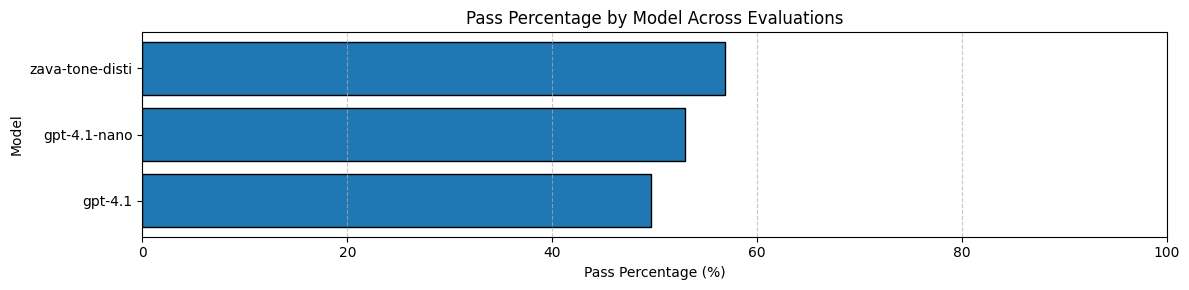

Fetching scores...

Score Summary Table:
          Model                         Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
zava-tone-disti zava-tone-posttrain-evaluation-3a095088          4.00      0.00     10.00            0.00            1.00            4.00            6.00            8.00
   gpt-4.1-nano zava-tone-posttrain-evaluation-3a095088          3.96      0.00     10.00            0.00            1.00            4.00            6.00            8.00
        gpt-4.1 zava-tone-posttrain-evaluation-3a095088          3.63      0.00     10.00            0.00            1.00            4.00            6.00            7.50


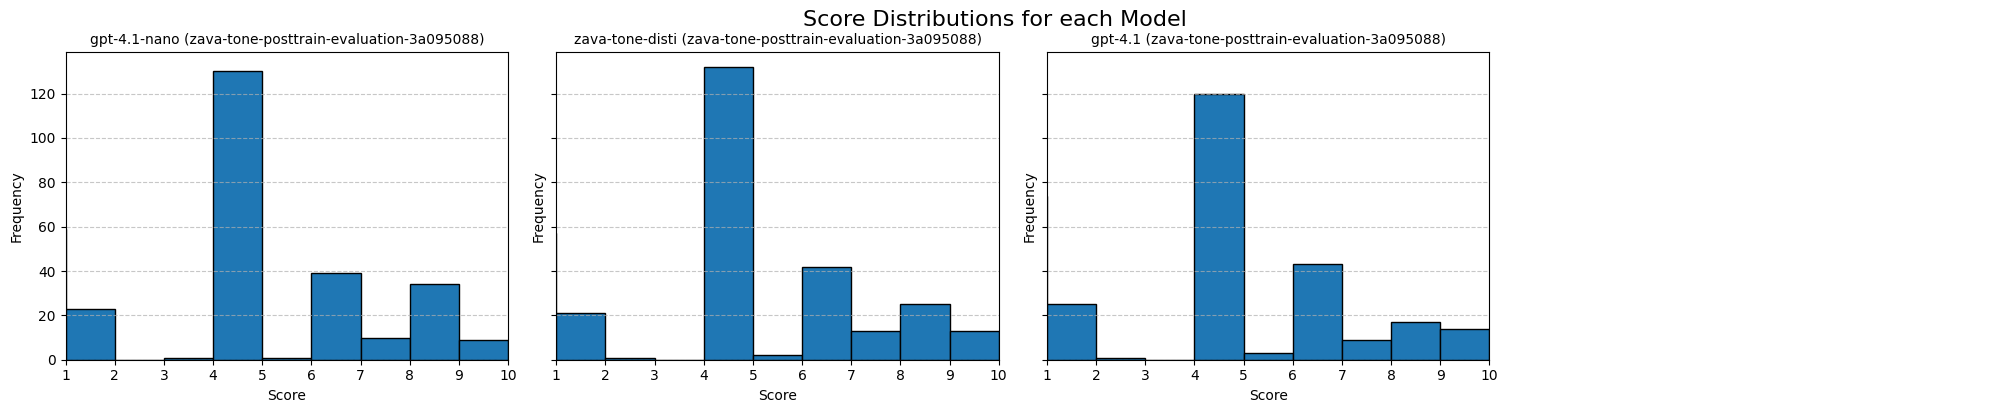

In [15]:
import importlib.util
spec = importlib.util.spec_from_file_location("eval_utils", "eval_utils.py")
eval_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(eval_utils)
display_evaluation_summary = eval_utils.display_evaluation_summary

display_evaluation_summary(client, [posttraining_eval.id], x_range=(1, 10))

Get Evaluation Runs: eval_695e3e857b248191ab2572d13de9e3e0
Get Evaluation Runs: eval_695e79992e108191ab8e9293622b0ba6

Combined Evaluation Summary
                                  Run ID                                                Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID                         Evaluation Name
evalrun_695e3e8987f081919bad7bffb91f886d                                        o4-mini-5429f3c9         o4-mini completed           80.612245            47.712418 eval_695e3e857b248191ab2572d13de9e3e0          32-zava-tone-baseline-5429f3c9
evalrun_695e3e8f417c8191b141964354a488b8                                   gpt-4.1-nano-5429f3c9    gpt-4.1-nano completed           61.437908            28.758170 eval_695e3e857b248191ab2572d13de9e3e0          32-zava-tone-baseline-5429f3c9
evalrun_695e3e8d4d74819191dfc19d908c17b1                                    gpt-4o-mini-5429f3c9     gpt-4o-mini completed     

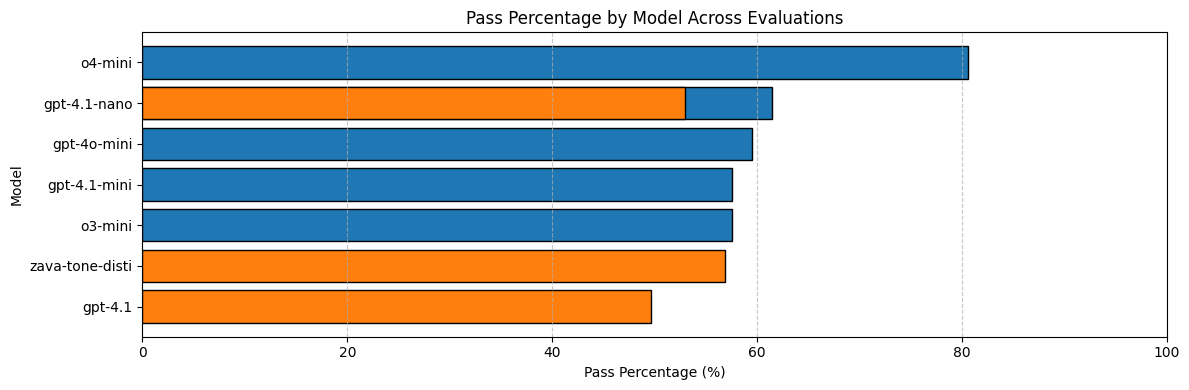

Fetching scores...

Score Summary Table:
          Model                         Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
        o3-mini          32-zava-tone-baseline-5429f3c9          4.26      0.00     10.00            0.00            0.00            4.00            8.00            9.00
        o4-mini          32-zava-tone-baseline-5429f3c9          3.72      0.00      9.00            0.00            4.00            4.00            4.00            5.00
   gpt-4.1-nano          32-zava-tone-baseline-5429f3c9          2.79      0.00      9.00            0.00            0.00            4.00            4.00            4.00
   gpt-4.1-mini          32-zava-tone-baseline-5429f3c9          2.63      0.00      9.00            0.00            0.00            4.00            4.00            4.00
    gpt-4o-mini          32-zava-tone-baseline-5429f3c9          2.61      0.00      9.00            0.00    

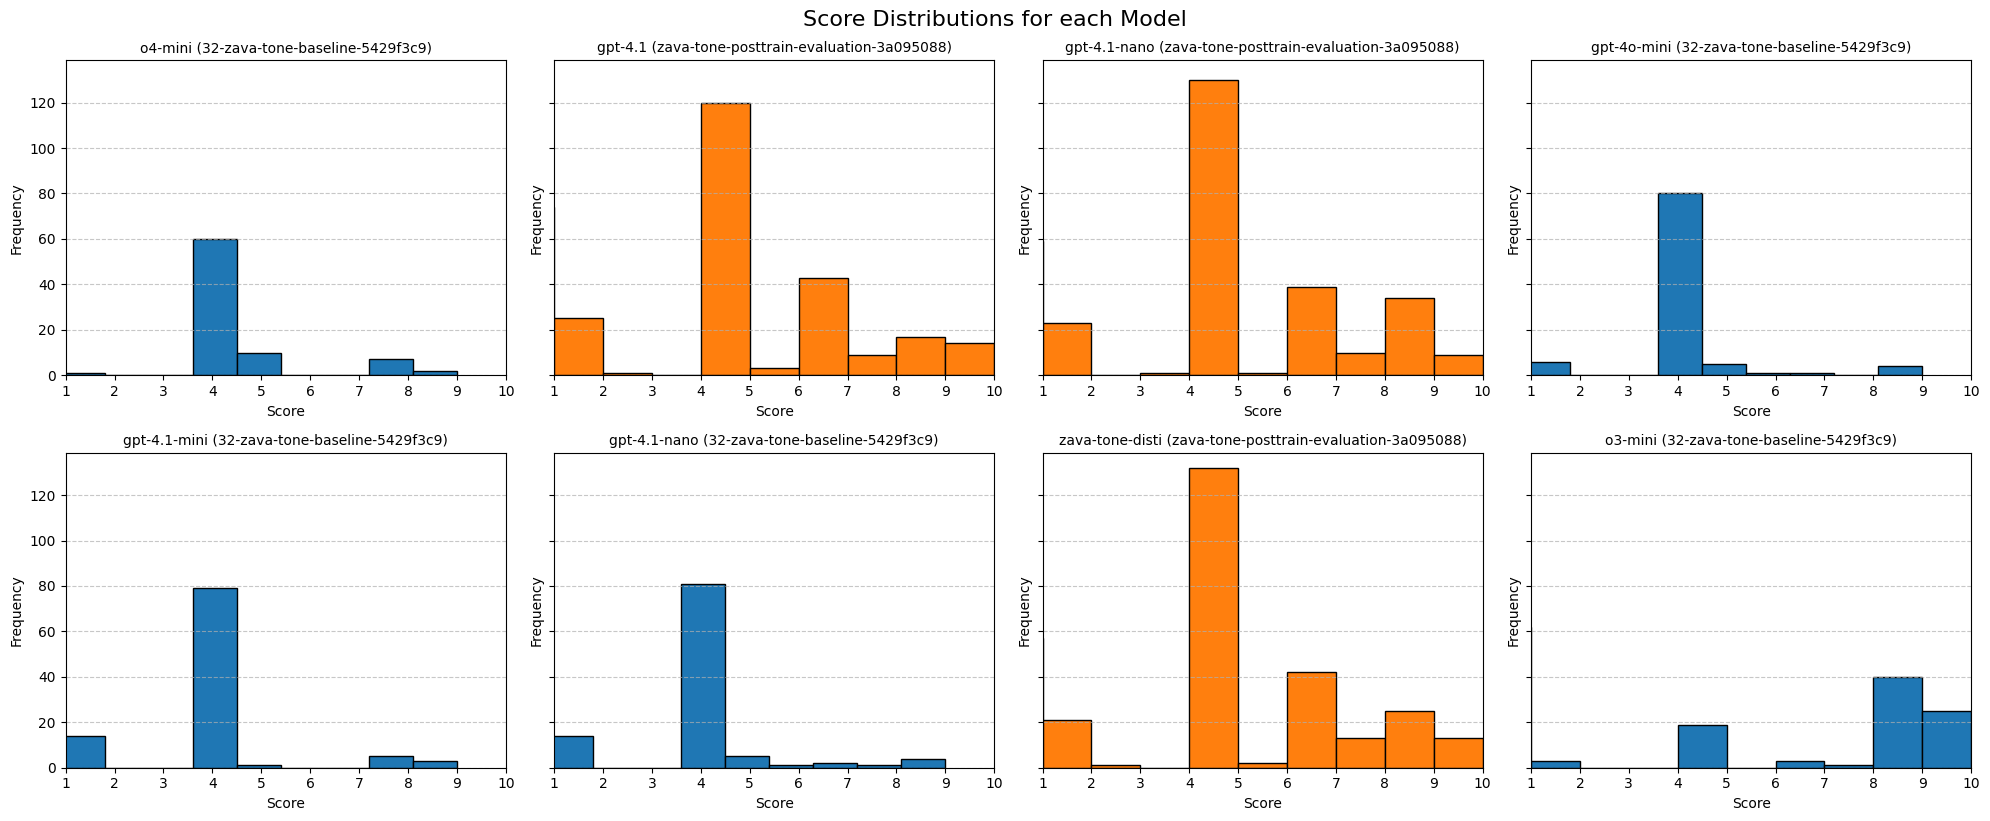

In [16]:
# And now let's put it all together.
# Let's visualize our post-training evaluation. Fingers crossed!
display_evaluation_summary(
    client, [baseline_eval.id, posttraining_eval.id], x_range=(1, 10))

## Step 5: 요약 및 정제 결과

축하합니다! Azure AI Foundry의 통합 평가 및 미세 조정 파이프라인을 사용하여 **엔드 투 엔드 모델 정제**를 성공적으로 구현했습니다.

### 🏆 주요 성과

**지식 이전 성공**: 대규모 추론 모델(GPT-4)에서 Zava 고객 서비스 특화 기능을 훨씬 작고 효율적인 모델(GPT-4.1-nano)로 성공적으로 정제했습니다.

### 🎯 기술적 성과

1. **✅ 교사 모델 선정**: 맞춤형 평가 도구를 통해 최적의 소스 모델을 식별했습니다.
2. **✅ 학습 데이터 생성**: 교사 출력 데이터를 기반으로 고품질 증류 데이터셋을 생성했습니다.
3. **✅ 학생 모델 학습**: 증류 기법을 사용하여 더 작은 모델을 미세 조정했습니다.
4. **✅ 품질 검증**: 지속적인 평가를 통해 지식 전달 효과를 검증했습니다.
5. **✅ 성능 최적화**: 비용 및 지연 시간을 크게 개선했습니다.

### 📊 비즈니스 영향

- **🤑 비용 절감**: 더 작은 모델 배포를 통해 토큰당 비용을 최소화했습니다.
- **🏎️ 성능 향상**: 응답 지연 시간을 개선하여 고객 경험을 향상시켰습니다.

- **📈 확장성**: 효율적인 리소스 사용으로 더 많은 고객 서비스를 제공할 수 있습니다.

- **🎯 품질 유지**: 체계적인 평가를 통해 Zava의 어조 및 스타일 표준을 유지했습니다.

### 🧠 혁신 하이라이트

**자동화된 지식** **지식 이전**: 수동으로 학습 데이터를 생성할 필요 없이, 평가 기준만 정의하고 AI 시스템이 지식 이전 프로세스를 처리하도록 함으로써 증류 과정을 성공적으로 완료했습니다.

**통합 파이프라인**: Azure AI 평가 및 미세 조정을 원활한 워크플로로 결합하여 다음을 자동으로 수행합니다.
1. 우수한 추론 모델에서 최적의 응답을 식별합니다.
2. 사용자 지정 평가 도구를 사용하여 일관된 품질 평가를 수행합니다.
3. 미세 조정을 통해 효율적인 모델로 지식을 이전합니다.

**측정 가능한 성공**: 객관적인 평가를 통해 증류 과정이 비용과 성능을 최적화하면서 품질을 유지했음을 검증했습니다.

---

**🎉 지능형 증류를 통해 고급 모델 최적화를 마스터하셨습니다!**

## Step 6: 다음 단계 및 고급 응용 프로그램

모델 증류 과정을 성공적으로 완료하셨습니다! 다음은 프로덕션 배포 및 고급 최적화를 위한 다음 단계입니다.

### 🚀 프로덕션 배포

- **배포 확장**: 개발자 티어에서 프로덕션 워크로드용 표준 티어로 전환
- **부하 테스트**: 실제 고객 서비스 볼륨에서 성능 검증
- **비용 모니터링**: 기존 모델 배포 대비 실제 절감액 추적
- **A/B 테스트**: 실제 고객 시나리오에서 정제된 모델과 기존 모델 비교

### 📈 고급 정제 기법

- **다중 교사 정제**: 여러 교사 모델의 지식 결합
- **단계적 정제**: 중간 크기 모델을 사용하여 단계적 최적화
- **도메인별 정제**: 다른 비즈니스 영역(영업, 지원, 기술)에 기법 적용
- **크로스 모달 정제**: 제품 추천을 위해 이미지-텍스트 모델로 확장

### 🔧 최적화 및 모니터링

- **지속적인 평가**: 맞춤형 자동화된 품질 모니터링 설정 평가 도구
- **모델 드리프트 감지**: 시간 경과에 따른 성능 저하 추적
- **피드백 루프**: 고객 만족도 데이터를 평가 기준에 통합
- **동적 재증류**: 품질 저하 시 모델 자동 갱신

### 🌐 엔터프라이즈 통합

- **MLOps 파이프라인**: Azure ML 및 DevOps와 통합하여 자동 배포
- **에이전트 프레임워크**: LangChain, Semantic Kernel 또는 사용자 지정 프레임워크와 결합
- **엣지 배포**: 엣지 컴퓨팅 환경에 최적화
- **다국어 지원**: 다국어 고객 서비스로 증류 기능 확장

### 📚 추가 학습

- **모델 압축**: 효율성 향상을 위한 양자화 및 가지치기 탐색
- **강화 학습**: RLHF를 사용하여 품질 향상
- **사용자 지정 아키텍처**: 작업별 모델 아키텍처 연구
- **평가 과학**: 더욱 정교한 사용자 지정 평가 도구 개발 지표

---

### 🎯 증류 성공 검증

구현 결과는 다음을 입증해야 합니다.
- **품질 유지**: 맞춤형 채점기에서 학생 모델 점수가 교사 점수와 유사해야 합니다.
- **성능 향상**: 응답 시간 및 비용 효율성 측면에서 측정 가능한 개선이 있어야 합니다.
- **확장성**: 증가하는 고객 서비스량을 처리할 수 있어야 합니다.
- **일관성**: Zava 브랜드 표준을 안정적으로 준수해야 합니다.

**지능형 모델 최적화로 AI 배포 전략을 혁신할 준비가 되셨나요? 이제 기반이 마련되었습니다!** 🎉